# Introduction to PyMC3

## Objectives and takeaways for notebooks 1a-1d
1. The main objective of notebooka 1a and 1b is to get familiar with the workflow of building a Bayesian model and with PyMC3.
2. Notebooks 1c and 1d analytically solve simple problems and compare the solutions with numerically estimated solutions.
3. Note: Designing and arguing for/against priors is one of the tougher parts of Bayesian analysis. This is definitely not a topic for the initial notebooks.

### Instruction manual
1. There is noneed to spend too much time researching individual terms you don't know. We will dive deeper in later chapters.
2. **Let's have fun doing this - remember that this is for us.**
3. Do not worry if you don't understand everything (this is likely and expected) - the idea is to get acquainted with the workflow and understand the syntax at an introductory/high level.

In other words, **don't panic and carry a towel :)**.

## Overview of constructing a Bayesian model

Gelman et al. [3] break down the business of Bayesian analysis into three primary steps:

1. Specify a full probability model, including all parameters, data, transformations, missing values and predictions that are of interest.
2. Calculate the posterior distribution of the unknown quantities in the model, conditional on the data.
3. Perform model checking to evaluate the quality and suitablility of the model.

While each of these steps is challenging, it is the second step that is the most difficult for non-trivial models, and was a bottleneck for the adoption of Bayesian methods for decades. 

### Bayesian Inference

At this point, we should all be familiar with **Bayes Formula**:

![bayes formula](images/bayes_formula.png)

The equation expresses how our beliefs about the value of \\(\theta\\), as expressed by the **prior distribution** \\(P(\theta)\\) are reallocated following the observation of the data \\(y\\), as expressed by the posterior distribution.  Computing the posterior distribution is called the **inference problem**, and is typically the goal of Bayesian analysis.

The innocuous denominator \\(Pr(y)\\) (the model **evidence**, or **marginal likelihood**) often cannot be calculated directly, and is actually the expression in the numerator, integrated over all \\(\theta\\):

<div style="font-size: 150%;">  
\\[Pr(\theta|y) = \frac{Pr(y|\theta)Pr(\theta)}{\int Pr(y|\theta)Pr(\theta) d\theta}\\]
</div>

Computing this integral, which may involve many variables, is generally intractible with analytic methods. This is the major compuational hurdle for Bayesian analysis.  Numerical methods circumvent this problem via various tricks as we will see.

## A Motivating Example: Linear Regression

We first consider a simple Bayesian linear regression model with normal priors for the parameters. We are interested in predicting outcomes $Y$ as normally-distributed observations with an expected value $\mu$ that is a linear function of two predictor variables, $X_1$ and $X_2$.

$$\begin{aligned} 
Y  &\sim \mathcal{N}(\mu, \sigma^2) \\
\mu &= \alpha + \beta_1 X_1 + \beta_2 X_2
\end{aligned}$$

where $\alpha$ is the intercept, and $\beta_i$ is the coefficient for covariate $X_i$, while $\sigma$ represents the observation error. Since we are constructing a Bayesian model, the unknown variables in the model must be assigned a prior distribution. We choose zero-mean normal priors with variance of 100 for both regression coefficients, which corresponds to *weak* information regarding the true parameter values. We choose a half-normal distribution (normal distribution bounded at zero) as the prior for $\sigma$.

$$\begin{aligned} 
\alpha &\sim \mathcal{N}(0, 100) \\
\beta_i &\sim \mathcal{N}(0, 100) \\
\sigma &\sim \lvert\mathcal{N}(0, 1){\rvert}
\end{aligned}$$

### Generating data

We simulate the (artificial) data from this model using only NumPy's `random` module.  This is an arbitrary choice, we could just have fixed arrays for $X_1$ and $X_2$.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np

In [2]:
# Initialize random number generator
#np.random.seed(123)
np.random.seed(13457693)

# we run the random number generator for 10000 samples
np.sum(np.random.randn(10000))

# We will generate a dataset of 100 samples.
size = 100

X1 = np.array([-1.0856306 ,  0.99734545,  0.2829785 , -1.50629471, -0.57860025,
                1.65143654, -2.42667924, -0.42891263,  1.26593626, -0.8667404 ,
               -0.67888615, -0.09470897,  1.49138963, -0.638902  , -0.44398196,
               -0.43435128,  2.20593008,  2.18678609,  1.0040539 ,  0.3861864 ,
                0.73736858,  1.49073203, -0.93583387,  1.17582904, -1.25388067,
               -0.6377515 ,  0.9071052 , -1.4286807 , -0.14006872, -0.8617549 ,
               -0.25561937, -2.79858911, -1.7715331 , -0.69987723,  0.92746243,
               -0.17363568,  0.00284592,  0.68822271, -0.87953634,  0.28362732,
               -0.80536652, -1.72766949, -0.39089979,  0.57380586,  0.33858905,
               -0.01183049,  2.39236527,  0.41291216,  0.97873601,  2.23814334,
               -1.29408532, -1.03878821,  1.74371223, -0.79806274,  0.02968323,
                1.06931597,  0.89070639,  1.75488618,  1.49564414,  1.06939267,
               -0.77270871,  0.79486267,  0.31427199, -1.32626546,  1.41729905,
                0.80723653,  0.04549008, -0.23309206, -1.19830114,  0.19952407,
                0.46843912, -0.83115498,  1.16220405, -1.09720305, -2.12310035,
                1.03972709, -0.40336604, -0.12602959, -0.83751672, -1.60596276,
                1.25523737, -0.68886898,  1.66095249,  0.80730819, -0.31475815,
               -1.0859024 , -0.73246199, -1.21252313,  2.08711336,  0.16444123,
                1.15020554, -1.26735205,  0.18103513,  1.17786194, -0.33501076,
                1.03111446, -1.08456791, -1.36347154,  0.37940061, -0.37917643])


X2 = np.array([ 0.12841094, -0.39557759,  0.14245293,  0.51966079, -0.0049252 ,
                0.00682843,  0.0359099 , -0.37239514,  0.08522933, -0.32108195,
               -0.08553592,  0.24857391, -0.14704339,  0.1002498 ,  0.20254781,
                0.05574817, -0.27418969, -0.06649506,  0.39188227, -0.40500915,
               -0.0551572 , -0.11042161,  0.02414947,  0.14964312,  0.32173819,
               -0.05404648,  0.16246827,  0.09994803,  0.09486946, -0.11278479,
               -0.19946429, -0.22000862, -0.15128744,  0.06433732,  0.15218988,
                0.06469377, -0.10979102,  0.36119402,  0.30377312, -0.07080002,
               -0.16468628,  0.02604299,  0.25345973,  0.066553  ,  0.11130974,
               -0.04241602,  0.09125418,  0.30890889, -0.04793376,  0.02866155,
                0.0507633 ,  0.05674507, -0.28237778, -0.37537373, -0.20393101,
                0.03358846,  0.11077123, -0.10613491,  0.2754515 , -0.02863519,
                0.0040632 , -0.03879277,  0.02680536,  0.14089481,  0.13313069,
               -0.17968459,  0.30473276, -0.21900529,  0.0158454 , -0.05487931,
               -0.20979834, -0.01502412, -0.14816275,  0.01458145,  0.08061719,
                0.29438587,  0.06147684, -0.12224507, -0.07832396,  0.02799562,
                0.01869217,  0.29191785,  0.27907059, -0.07178719, -0.10972843,
               -0.51141092, -0.10978408, -0.19561154, -0.07096489,  0.07831685,
                0.03543847, -0.0059936 ,  0.03991642, -0.02522355,  0.03940379,
               -0.646211  , -0.0538587 , -0.02217014, -0.06825234, -0.04358925])

X1 = np.random.randn(size)
X2 = np.random.randn(size)*0.2

Now we will fix values of the model parameters $\alpha, \beta_1, \beta_2$ and $\sigma$ and use those fixed values to create the observations $Y$ to build a complete dataset of triples $X_1, X_2, Y$.

In [3]:
# True parameter values - this is our model and what we are trying to estimate
true_alpha, true_sigma = 1.0, 1.0
true_beta = [1.0, 2.5]

# Here is where we compute Y from the simulated X1 and X2 using the true model parameters
# The form of the model implements the first equation above.
noise = np.random.randn(size)*true_sigma
Y_obs = true_alpha + true_beta[0]*X1 + true_beta[1]*X2 + noise

# Let's print the first ten values of each variable.
# In the following, each triple is one "observation"
list(zip(X1[:10], X2[:10], Y_obs[:10]))

[(-1.020013760737888, -0.1090766026285005, -1.496438877470449),
 (-0.1667047602114, 0.1709987885161575, 1.504373517012821),
 (0.44457239101308027, 0.2044061803326195, 3.0912617072525075),
 (0.9103844493059361, -0.18661877514015132, 1.6107666677778671),
 (0.16507048015042997, -0.051603795815404446, 2.366383366590987),
 (-0.8800291894574969, -0.22925514167178168, -1.5886798329274123),
 (0.42832516229495615, 0.07398042518547925, 1.1466191892759807),
 (1.180863713113565, -0.018092177983715162, 2.2085271531509068),
 (-1.2857169376092508, -0.25501001759105046, -0.6451585491478236),
 (-0.6490469448636428, 0.29664054313640154, 0.4688189540366199)]

Here is what the simulated data look like. We use the `pylab` module from the plotting library matplotlib. 

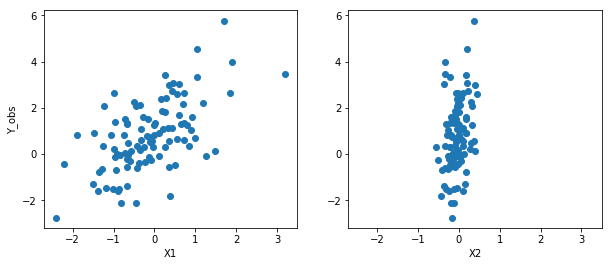

In [4]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y_obs)
axes[1].scatter(X2, Y_obs)
axes[0].set_ylabel('Y_obs'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2');

### Model Specification

Specifying this model in PyMC3 is straightforward because the syntax is close to the statistical notation. For the most part, each line of Python code corresponds to a line in the model notation above. 

First, we import PyMC. We use the convention of importing it as `pm`.

In [5]:
import pymc3 as pm

/Users/vejmelka/Packages/anaconda/envs/bayes/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Now we build our model, which we will present in full first, then explain each part line-by-line.

In [6]:
basic_model = pm.Model()

with basic_model:
    
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.HalfNormal('sigma', sd=1)
    
    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2
    
    # Likelihood (sampling distribution) of observations
    Y = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y_obs)

The first line,

```python
basic_model = Model()
```

creates a new `Model` object which is a container for the model random variables.

Following instantiation of the model, the subsequent specification of the model components is performed inside a  `with` statement:

```python
with basic_model:
```
This creates a *context manager*, with our `basic_model` as the context, that includes all statements until the indented block ends. This means all PyMC3 objects introduced in the indented code block below the `with` statement are added to the model behind the scenes. Absent this context manager idiom, we would be forced to manually associate each of the variables with `basic_model` right after we create them. If you try to create a new random variable without a `with model:` statement, it will raise an error since there is no obvious model for the variable to be added to.

The first three statements in the context manager:

```python
alpha = Normal('alpha', mu=0, sd=10)
beta = Normal('beta', mu=0, sd=10, shape=2)
sigma = HalfNormal('sigma', sd=1)
```
create a **stochastic** random variables with a Normal prior distributions for the regression coefficients with a mean of 0 and standard deviation of 10 for the regression coefficients, and a [half-normal](https://en.wikipedia.org/wiki/Half-normal_distribution) distribution for the standard deviation of the observations, $\sigma$. These are stochastic because their values are partly determined by their parents in the dependency graph of random variables and partly random (or stochastic). 

We call the `Normal` constructor to create a random variable to use as a normal prior. The first argument is always the *name* of the random variable, which should almost always match the name of the Python variable being assigned to, since it sometimes used to retrieve the variable from the model for summarizing output. The remaining required arguments for a stochastic object are the parameters, in this case `mu`, the mean, and `sd`, the standard deviation, which we assign hyperparameter values for the model. In general, a distribution's parameters are values that determine the location, shape or scale of the random variable, depending on the parameterization of the distribution. Most commonly used distributions, such as `Beta`, `Exponential`, `Categorical`, `Gamma`, `Binomial` and many others, are available in PyMC3.

The `beta` variable has an additional `shape` argument to denote it as a vector-valued parameter of size 2. The `shape` argument is available for all distributions and specifies the length or shape of the random variable, but is optional for scalar variables, since it defaults to a value of one. It can be an integer, to specify an array, or a tuple, to specify a multidimensional array (*e.g.* `shape=(5,7)` makes random variable that takes on 5 by 7 matrix values). 

Detailed notes about distributions, sampling methods and other PyMC3 functions are available via the `help` function.

In [7]:
help(pm.Normal) #try help(Model), help(Uniform) or help(basic_model)

Help on class Normal in module pymc3.distributions.continuous:

class Normal(pymc3.distributions.distribution.Continuous)
 |  Univariate normal log-likelihood.
 |  
 |  .. math::
 |  
 |     f(x \mid \mu, \tau) =
 |         \sqrt{\frac{\tau}{2\pi}}
 |         \exp\left\{ -\frac{\tau}{2} (x-\mu)^2 \right\}
 |  
 |  ========  ==========================================
 |  Support   :math:`x \in \mathbb{R}`
 |  Mean      :math:`\mu`
 |  Variance  :math:`\dfrac{1}{\tau}` or :math:`\sigma^2`
 |  ========  ==========================================
 |  
 |  Normal distribution can be parameterized either in terms of precision
 |  or standard deviation. The link between the two parametrizations is
 |  given by
 |  
 |  .. math::
 |  
 |     \tau = \dfrac{1}{\sigma^2}
 |  
 |  .. plot::
 |  
 |      import matplotlib.pyplot as plt
 |      import numpy as np
 |      import scipy.stats as st
 |      x = np.linspace(-5.0, 5.0, 1000)
 |      fig, ax = plt.subplots()
 |      f = lambda mu, sd : st.

Having defined the priors, the next statement creates the expected value `mu` of the outcomes, specifying the linear relationship:

```python
mu = alpha + beta[0]*X1 + beta[1]*X2
```
This creates a **deterministic** random variable, which implies that its value is *completely* determined by its parents' values. That is, there is no uncertainty beyond that which is inherent in the parents' values. Here, `mu` is just the sum of the intercept `alpha` and the two products of the coefficients in `beta` and the predictor variables, whatever their values may be. 

PyMC3 random variables and data can be arbitrarily added, subtracted, divided, multiplied together and indexed-into to create new random variables. This allows for great model expressivity. Many common mathematical functions like `sum`, `sin`, `exp` and linear algebra functions like `dot` (for inner product) and `inv` (for inverse) are also provided. 

The final line of the model, defines `Y_obs`, the sampling distribution of the outcomes in the dataset.

```python
Y_obs = Normal('Y_obs', mu=mu, sd=sigma, observed=Y)
```

This is a special case of a stochastic variable that we call an **observed stochastic**, and represents the data likelihood of the model. It is identical to a standard stochastic, except that its `observed` argument, which passes the data to the variable, indicates that the values for this variable were observed, and should not be changed by any fitting algorithm applied to the model. The data can be passed in the form of either a `numpy.ndarray` or `pandas.DataFrame` object.

Notice that, unlike for the priors of the model, the parameters for the normal distribution of `Y_obs` are not fixed values, but rather are the deterministic object `mu` and the stochastic `sigma`. This creates parent-child relationships between the likelihood and these two variables.

### Model fitting

Having completely specified our model, the next step is to obtain posterior estimates for the unknown variables in the model. Ideally, we could calculate the posterior estimates analytically, but for most non-trivial models, this is not feasible. We will consider two approaches, whose appropriateness depends on the structure of the model and the goals of the analysis: finding the *maximum a posteriori* (MAP) point using optimization methods, and computing summaries based on samples drawn from the posterior distribution using Markov Chain Monte Carlo (MCMC) sampling methods.

#### Maximum a posteriori methods

The **maximum a posteriori (MAP)** estimate for a model, is the mode of the posterior distribution and is generally found using numerical optimization methods. This is often fast and easy to do, but only gives a point estimate for the parameters and can be biased if the mode isn't representative of the distribution. PyMC3 provides this functionality with the `find_MAP` function.

Below we find the MAP for our original model. The MAP is returned as a parameter **point**, which is always represented by a Python dictionary of variable names to NumPy arrays of parameter values. 

In [8]:
map_estimate = pm.find_MAP(model=basic_model)
    
map_estimate

logp = -163.8, ||grad|| = 17.741: 100%|██████████| 19/19 [00:00<00:00, 1071.03it/s] 


{'alpha': array(1.03785084),
 'beta': array([0.99586387, 2.49470029]),
 'sigma': array(1.09422551),
 'sigma_log__': array(0.09004682)}

By default, `find_MAP` uses the Broyden–Fletcher–Goldfarb–Shanno ([explanation](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm) for those interested) optimization algorithm to find the maximum of the log-posterior but also allows selection of other optimization algorithms from the `scipy.optimize` module. For example, below we use Powell's method [4] to find the MAP.

In [9]:
from scipy import optimize

map_estimate = pm.find_MAP(model=basic_model, fmin=optimize.fmin_powell)
    
map_estimate

/Users/vejmelka/Packages/anaconda/envs/bayes/lib/python3.6/site-packages/pymc3/tuning/starting.py:92: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  warnings.warn('In future versions, set the optimization algorithm with a string. '
logp = -162.25:   4%|▍         | 216/5000 [00:00<00:03, 1292.82it/s]

Optimization terminated successfully.
         Current function value: 162.027957
         Iterations: 5
         Function evaluations: 216


{'alpha': array(1.03965219),
 'beta': array([0.99591043, 2.49629189]),
 'sigma': array(1.09549174),
 'sigma_log__': array(0.09120334)}

It is important to note that the MAP estimate is not always reasonable, especially if the mode is at an extreme location of the probability distribution. This can be a subtle issue; with high dimensional posteriors, one can have areas of extremely high density but low total probability because the volume is very small.

Most techniques for finding the MAP estimate also only find a *local* optimum (which is often good enough), but can fail badly for multimodal posteriors if the different modes are meaningfully different.

#### Sampling methods

Though finding the MAP is a fast and easy way of obtaining estimates of the unknown model parameters, it is limited because there is no associated estimate of uncertainty produced with the MAP estimates. Instead, a simulation-based approach such as Markov chain Monte Carlo (MCMC) can be used to obtain a Markov chain of values that, given the satisfaction of certain conditions, are indistinguishable from samples from the posterior distribution and therefore quantify the uncertainty in the posterior distribution.

**PyMC3 Note** that `pm.sample` ([ref](https://docs.pymc.io/api/inference.html#pymc3.sampling.sample)) will by default sample 1500 samples and **throw away the first 500 samples**, as they are considered 'burn-in' samples. In the following example, we throw away 500 samples and compute additional 5000 samples that we keep.  The `chains` parameter is set to 1 as PyMC3 can run multiple chains in parallel under some conditions but we don't wish to trigger this behavior now as multiple traces are then generated.

In [10]:
with basic_model:
    # draw posterior samples
    trace = pm.sample(draws=5000, tune=500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/vejmelka/Packages/anaconda/envs/bayes/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_log__, beta, alpha]
100%|██████████| 5500/5500 [00:08<00:00, 646.93it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


The `sample` function runs the samping methods for the given number of iterations and returns a `Trace` object containing the samples collected, in the order they were collected. The `trace` object can be queried in a similar way to a `dict` containing a map from variable names to `numpy.array`s. The first dimension of the array is the sampling index and the later dimensions match the shape of the variable. We can see the last 5 values for the `alpha` variable as follows:

In [11]:
trace['alpha'][-5:]

array([1.05562625, 1.10157715, 0.78869467, 0.78047526, 0.90700551])

### Posterior analysis
`PyMC3` provides plotting and summarization functions for inspecting the sampling output. A simple posterior plot can be created using `traceplot`.

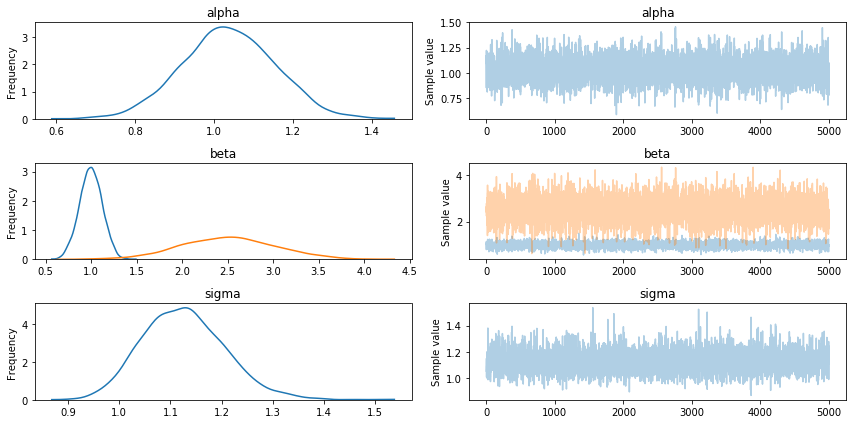

In [12]:
_ = pm.traceplot(trace)

The left column consists of a smoothed histogram (using kernel density estimation) of the marginal posteriors of each stochastic random variable while the right column contains the samples of the Markov chain plotted in sequential order. The `beta` variable, being vector-valued, produces two histograms and two sample traces, corresponding to both predictor coefficients.

## Exercise
Can you reduce the sampling so the results are totally different? Note, the trace contains all the samples, so just go ahead and use indexing to reduce the number of samples used for posterior plot (and use samples from start) instead of going back and changing the sampling initially.

- Can you make the graph on the right clearly irregular?
- When you compare posterior estimates for the betas in your traceplot below and in the (stabilized) traceplot above, can you produce a large difference?
- Where are the differences you see?

In addition, the `pm.summary` ([ref](https://docs.pymc.io/api/stats.html#pymc3.stats.summary)) function provides a text-based output of common posterior statistics:

In [13]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,1.036853,0.118112,0.001730,0.802199,1.257943
beta__0,0.995550,0.124116,0.001694,0.764926,1.251439
beta__1,2.498108,0.524709,0.007172,1.514766,3.554042
sigma,1.126914,0.080847,0.001065,0.972151,1.280354


## References

1. Salvatier, J., Wiecki, T. V., & Fonnesbeck, C. (2016). Probabilistic programming in Python using PyMC3. PeerJ Computer Science, 2(2), e55. http://doi.org/10.7717/peerj-cs.55
2. Getting started with PyMC3 (Apache License). http://docs.pymc.io/notebooks/getting_started.html
3. Gelman A. et al. [Bayesian Data Analysis](http://www.stat.columbia.edu/~gelman/book/), Chapman and Hall/CRC; 3 edition, 2013.
4. Powell, M. An efficient method for finding the minimum of a function of several variables without calculating derivatives. Computer Journal. 7 (2): 155–162, 1964.